In [1]:
import plotly.express as px
import pandas as pd
import seaborn as sns
import numpy as np
import plotly
import matplotlib.pyplot as plt
import scipy
px.defaults.template = 'seaborn'
px.defaults.width = 700
px.defaults.height = 500
pd.set_option('display.max_columns', 30)

import warnings
warnings.simplefilter(action='ignore')

In [2]:
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import cross_val_score

In [3]:
#Loading the data
df = pd.read_csv('Automobile price data _Raw_.csv')
df

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,-1,95,volvo,gas,std,four,sedan,rwd,front,109.1,188.8,68.9,55.5,2952,ohc,four,141,mpfi,3.78,3.15,9.5,114,5400,23,28,16845
201,-1,95,volvo,gas,turbo,four,sedan,rwd,front,109.1,188.8,68.8,55.5,3049,ohc,four,141,mpfi,3.78,3.15,8.7,160,5300,19,25,19045
202,-1,95,volvo,gas,std,four,sedan,rwd,front,109.1,188.8,68.9,55.5,3012,ohcv,six,173,mpfi,3.58,2.87,8.8,134,5500,18,23,21485
203,-1,95,volvo,diesel,turbo,four,sedan,rwd,front,109.1,188.8,68.9,55.5,3217,ohc,six,145,idi,3.01,3.40,23.0,106,4800,26,27,22470


In [4]:
#Cleaning the data and encoding the ordinal columns
df['normalized-losses'].replace('?', np.nan, inplace=True)
df['normalized-losses'].fillna(df['normalized-losses'].median(), inplace=True)
df['normalized-losses'] = df['normalized-losses'].astype('int')

df.replace({'num-of-doors': '?'}, np.nan, inplace=True)
df.dropna(subset=['num-of-doors'], inplace=True)
df['num-of-doors'] = df['num-of-doors'].replace(['four', 'two'], [4, 2])
df['num-of-doors'].dtype

df['num-of-cylinders'] = df['num-of-cylinders'].replace(['four', 'six', 'five', 'eight', 'two', 'twelve', 'three'],
                                                        [4, 6, 5, 8, 2, 12, 3])

filt = df['bore'] != '?'
df = df[filt]
df['bore'] = df['bore'].astype('float')

df['stroke'] = pd.to_numeric(df['stroke'])

df['horsepower'] = df['horsepower'].replace('?', np.nan)
df.dropna(subset=['horsepower'], inplace=True)
df['horsepower'] = pd.to_numeric(df['horsepower'])

df['peak-rpm'] = df['peak-rpm'].astype('float')

df = df[df['price'] != '?']
df['price'] = df['price'].astype('float')
df

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,115,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,4,130,mpfi,3.47,2.68,9.0,111,5000.0,21,27,13495.0
1,3,115,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,4,130,mpfi,3.47,2.68,9.0,111,5000.0,21,27,16500.0
2,1,115,alfa-romero,gas,std,2,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,6,152,mpfi,2.68,3.47,9.0,154,5000.0,19,26,16500.0
3,2,164,audi,gas,std,4,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,4,109,mpfi,3.19,3.40,10.0,102,5500.0,24,30,13950.0
4,2,164,audi,gas,std,4,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,5,136,mpfi,3.19,3.40,8.0,115,5500.0,18,22,17450.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,-1,95,volvo,gas,std,4,sedan,rwd,front,109.1,188.8,68.9,55.5,2952,ohc,4,141,mpfi,3.78,3.15,9.5,114,5400.0,23,28,16845.0
201,-1,95,volvo,gas,turbo,4,sedan,rwd,front,109.1,188.8,68.8,55.5,3049,ohc,4,141,mpfi,3.78,3.15,8.7,160,5300.0,19,25,19045.0
202,-1,95,volvo,gas,std,4,sedan,rwd,front,109.1,188.8,68.9,55.5,3012,ohcv,6,173,mpfi,3.58,2.87,8.8,134,5500.0,18,23,21485.0
203,-1,95,volvo,diesel,turbo,4,sedan,rwd,front,109.1,188.8,68.9,55.5,3217,ohc,6,145,idi,3.01,3.40,23.0,106,4800.0,26,27,22470.0


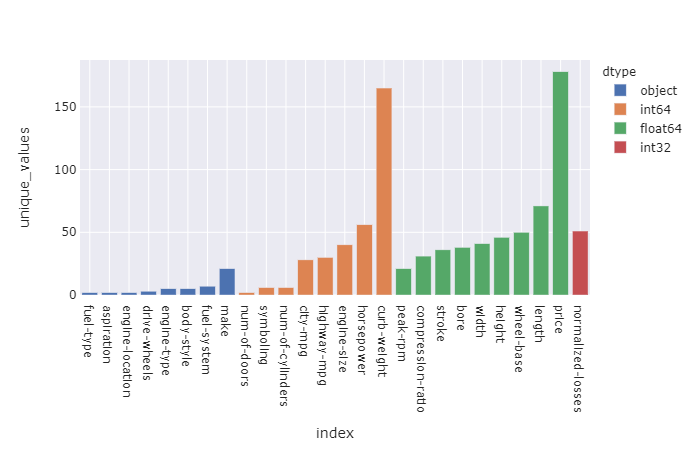

In [5]:
value_counts = df.apply(lambda x: len(x.value_counts()))
df_value_counts = pd.DataFrame([value_counts, df.dtypes]).T
df_value_counts.columns = ['unique_values', 'dtype']
df_value_counts = df_value_counts.sort_values('unique_values')
fig = px.bar(df_value_counts,x=df_value_counts.index, color='dtype', y='unique_values')
fig.show(renderer='png')

In [6]:
X = df.copy()
y = X.pop('price')
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.2)

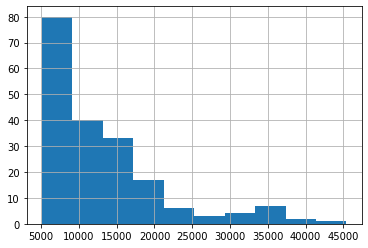

In [7]:
#Data Distribution
y.hist()

In [8]:
from scipy.stats import boxcox
from scipy.stats import skew , kurtosis

print('no transform')
print('skew: ', round(skew(y), 2))
print('kurtosis', round(kurtosis(y), 2))
print()

y_ = np.log(y)
print('log transform')
print('skew: ', round(skew(y_), 2))
print('kurtosis', round(kurtosis(y_), 2))
print()

y_ = np.sqrt(y)
print('sqrt transform')
print('skew: ', round(skew(y_), 2))
print('kurtosis', round(kurtosis(y_), 2))
print()

from sklearn.preprocessing import PowerTransformer
trans = PowerTransformer(method='box-cox')
y_ = trans.fit_transform(y[:,None])
print('box-cox transformation')
print('skew: ', round(skew(y_)[0], 2))
print('kurtosis', round(kurtosis(y_)[0], 2))

no transform
skew:  1.75
kurtosis 2.87

log transform
skew:  0.66
kurtosis -0.29

sqrt transform
skew:  1.18
kurtosis 0.93

box-cox transformation
skew:  0.1
kurtosis -0.89


Text(0.5, 1.0, 'test')

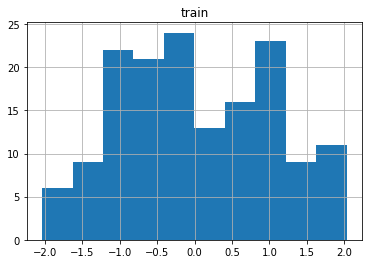

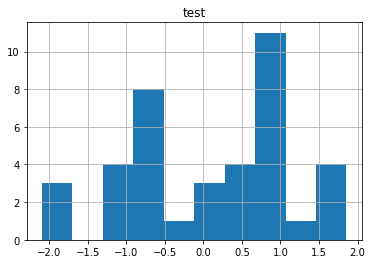

In [9]:
#carrying box cox transformation forward
trans = PowerTransformer(method='box-cox')
y_train_trans = trans.fit_transform(y_train[:,None])
pd.DataFrame(y_train_trans).hist()
plt.title('train')
y_test_trans = trans.transform(y_test[:,None])
pd.DataFrame(y_test_trans).hist()
plt.title('test')

In [10]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    print('Train r2 score: ', r2_score(y_train, model.predict(X_train)))
    print('Test r2 score: ', r2_score(y_test, model.predict(X_test)))
    fig = plt.figure(figsize=(12,6))
    fig.suptitle('Prediction vs Actual')
    fig.add_subplot(121)
    sns.scatterplot(x=y_train, y = model.predict(X_train))
    plt.title('train set')
    fig.add_subplot(122)
    sns.scatterplot(x=y_test, y = model.predict(X_test), color='red')
    plt.title('test set')
    #fig = plt.figure(figsize=(12,6))
    #fig.suptitle('Residual Error & homoscedasticity')
    #fig.add_subplot(121)
    #sns.scatterplot(x=y_train, y = (y_train-model.predict(X_train)))
    #plt.title('train set')
    #fig.add_subplot(122)
    #sns.scatterplot(x=y_test, y = (y_test-model.predict(X_test)), color='red')
    #plt.title('test set')

In [11]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

def generate_ridge_model(**kwargs):
    ct = ColumnTransformer([("onehot", OneHotEncoder(sparse=False, handle_unknown ='ignore'), X.select_dtypes('object').columns),
                            ("standard_scaler", StandardScaler(), X.select_dtypes(exclude='object').columns)])
    model = TransformedTargetRegressor(regressor=Ridge(**kwargs), transformer=PowerTransformer(method='box-cox'))
    pipe = Pipeline([('feature_transformation', ct),
                     ('model', model)])
    return pipe

def generate_random_forrest_model(**kwargs):
    ct = ColumnTransformer([("onehot", OneHotEncoder(sparse=False, handle_unknown ='ignore'), X.select_dtypes('object').columns),
                            ("standard_scaler", StandardScaler(), X.select_dtypes(exclude='object').columns)])
    model = TransformedTargetRegressor(regressor=RandomForestRegressor(**kwargs), transformer=PowerTransformer(method='box-cox'))
    pipe = Pipeline([('feature_transformation', ct),
                     ('model', model)])
    return pipe

In [12]:
from sklearn.model_selection import GridSearchCV
pipe = generate_ridge_model()
parameters = {'model__regressor__alpha':[0.01, 0.1, 0.5, 1, 5, 10, 100, 1000, 10000]}
gs = GridSearchCV(pipe, parameters, cv=5)
gs.fit(X, y)
print(gs.best_params_)
print(gs.best_score_)

{'model__regressor__alpha': 1}
0.44910875632532904


[ 0.69563205  0.7926114  -0.14288753  0.56301081  0.33717704]
Train r2 score:  0.9532488306076508
Test r2 score:  0.6754475791050536


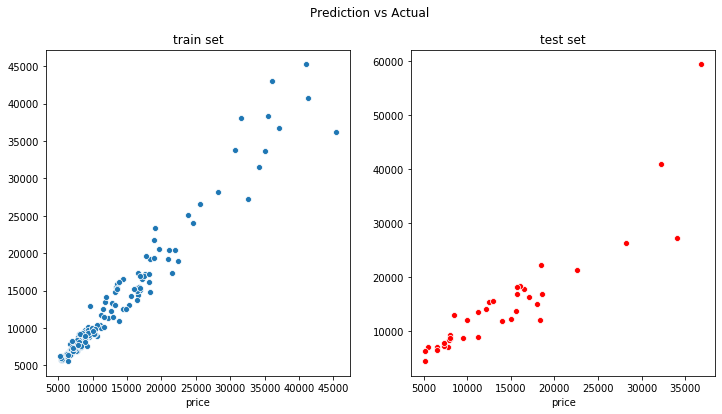

In [13]:
pipe = generate_ridge_model(alpha=1)
pipe.fit(X_train, y_train)
print(cross_val_score(pipe, X, y, cv=5))
evaluate_model(pipe, X_train, y_train, X_test, y_test)

In [14]:
'''
pipe = generate_random_forrest_model()
parameters = {'model__regressor__n_estimators':[10, 50, 100, 200],
              'model__regressor__criterion':['mse', 'mae'],
              'model__regressor__max_depth':[None, 10, 20],
              'model__regressor__min_samples_split' : [2, 4, 8],
              'model__regressor__min_samples_leaf' : [1, 2, 4],
             }
gs = GridSearchCV(pipe, parameters, cv=5)
gs.fit(X, y)
print(gs.best_params_)
print(gs.best_score_)
'''
#Obtained output
#{'model__regressor__criterion': 'mse', 'model__regressor__max_depth': None, 'model__regressor__min_samples_leaf': 1, 'model__regressor__min_samples_split': 2, 'model__regressor__n_estimators': 10}
#0.6888227121958135

"\npipe = generate_random_forrest_model()\nparameters = {'model__regressor__n_estimators':[10, 50, 100, 200],\n              'model__regressor__criterion':['mse', 'mae'],\n              'model__regressor__max_depth':[None, 10, 20],\n              'model__regressor__min_samples_split' : [2, 4, 8],\n              'model__regressor__min_samples_leaf' : [1, 2, 4],\n             }\ngs = GridSearchCV(pipe, parameters, cv=5)\ngs.fit(X, y)\nprint(gs.best_params_)\nprint(gs.best_score_)\n"

[ 0.6707725   0.81405088  0.93780371  0.9251341  -2.82588873  0.33584747
  0.91097858 -0.28061279  0.23333495  0.55928045]
Train mae 670.7628061373338
Test mae 1729.2468724184482
Train r2 score:  0.9830367983558518
Test r2 score:  0.9182808314340007


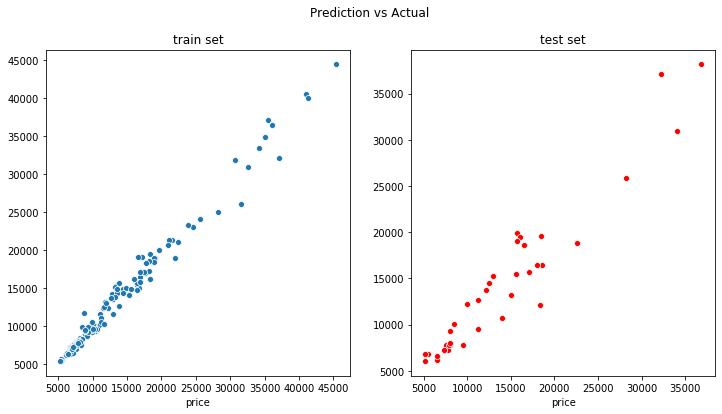

In [15]:
from sklearn.metrics import mean_absolute_error
pipe = generate_random_forrest_model(n_estimators=10,
                                     criterion='mse',
                                     max_depth=None,
                                     min_samples_split=2,
                                     min_samples_leaf=1)
pipe.fit(X_train, y_train)
print(cross_val_score(pipe, X, y, cv=10))
print('Train mae', mean_absolute_error(y_train, pipe.predict(X_train)))
print('Test mae', mean_absolute_error(y_test, pipe.predict(X_test)))
evaluate_model(pipe, X_train, y_train, X_test, y_test)

Train r2 score:  0.98237925916893
Test r2 score:  -1.927765348817823


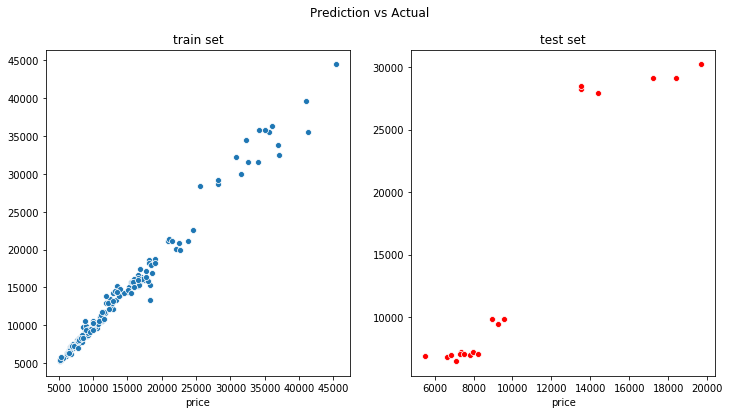

In [16]:
#Understanding what is going wrong with multiple cross validations
from sklearn.model_selection import KFold
kf = KFold(n_splits=10)
train_index, test_index = list(kf.split(X))[4]

X_train_issue, X_test_issue = X.iloc[train_index,:], X.iloc[test_index,:]
y_train_issue, y_test_issue = y.iloc[train_index], y.iloc[test_index]
pipe.fit(X_train_issue, y_train_issue)
evaluate_model(pipe, X_train_issue, y_train_issue, X_test_issue, y_test_issue)

In [17]:
#Data on which prodiction is highly correlated
filt = (pd.Series(y_test_issue) > 12500)
pd.DataFrame(X_test_issue).loc[filt,:]
#All nissan models going wrong

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg
101,0,128,nissan,gas,std,4,sedan,fwd,front,100.4,181.7,66.5,55.1,3095,ohcv,6,181,mpfi,3.43,3.27,9.0,152,5200.0,17,22
102,0,108,nissan,gas,std,4,wagon,fwd,front,100.4,184.6,66.5,56.1,3296,ohcv,6,181,mpfi,3.43,3.27,9.0,152,5200.0,17,22
103,0,108,nissan,gas,std,4,sedan,fwd,front,100.4,184.6,66.5,55.1,3060,ohcv,6,181,mpfi,3.43,3.27,9.0,152,5200.0,19,25
104,3,194,nissan,gas,std,2,hatchback,rwd,front,91.3,170.7,67.9,49.7,3071,ohcv,6,181,mpfi,3.43,3.27,9.0,160,5200.0,19,25
105,3,194,nissan,gas,turbo,2,hatchback,rwd,front,91.3,170.7,67.9,49.7,3139,ohcv,6,181,mpfi,3.43,3.27,7.8,200,5200.0,17,23
106,1,231,nissan,gas,std,2,hatchback,rwd,front,99.2,178.5,67.9,49.7,3139,ohcv,6,181,mpfi,3.43,3.27,9.0,160,5200.0,19,25


In [18]:
X_train_issue.make.value_counts()
#No nissan model available in the training data!

toyota           32
honda            13
subaru           12
volkswagen       12
mitsubishi       12
mazda            12
volvo            11
peugot           11
bmw               8
dodge             8
mercedes-benz     8
plymouth          7
audi              6
saab              6
porsche           4
jaguar            3
alfa-romero       3
chevrolet         3
isuzu             2
mercury           1
Name: make, dtype: int64

In [19]:
#Stratified model insuring all models are in test as well as in train data
X_stratified_train = []
y_stratified_test = []
def generate_stratified_split(df, target, stratified_on, test_size=0.2):
    X_train_s = []
    X_test_s = []
    y_train_s = []
    y_test_s = []
    for _, df_ in df.groupby(stratified_on):
        X_ = df_.copy()
        y_ = X_.pop(target)
        if len(X_)>1:
            X_train_,X_test_,y_train_,y_test_ = train_test_split(X_,y_, test_size = test_size)
        else:
            X_train_,X_test_,y_train_,y_test_ = X_, X_, y_, y_
        X_train_s.append(X_train_)
        X_test_s.append(X_test_)
        y_train_s.append(y_train_)
        y_test_s.append(y_test_)
    X_train_s = pd.concat(X_train_s, axis=0)
    X_test_s = pd.concat(X_test_s, axis=0)
    y_train_s = pd.concat(y_train_s, axis=0)
    y_test_s = pd.concat(y_test_s, axis=0)
    return X_train_s, X_test_s, y_train_s, y_test_s

X_train_s, X_test_s, y_train_s, y_test_s = generate_stratified_split(df, 'price', 'make', test_size=0.2)

In [20]:
print('unique make in train set: ', X_train_s.make.nunique())
print('unique make in test set: ', X_test_s.make.nunique())
print(X_train.shape)
print(X_test.shape)

unique make in train set:  21
unique make in test set:  21
(154, 25)
(39, 25)


[0.81856755 0.26289788 0.80204869 0.44766953 0.93018736 0.86094496
 0.6753898  0.82763826 0.93998964 0.84420739]
Train mae 1275.7228587283187
Test mae 1610.1086278320429
Train r2 score:  0.921360222047892
Test r2 score:  0.9263447856335689


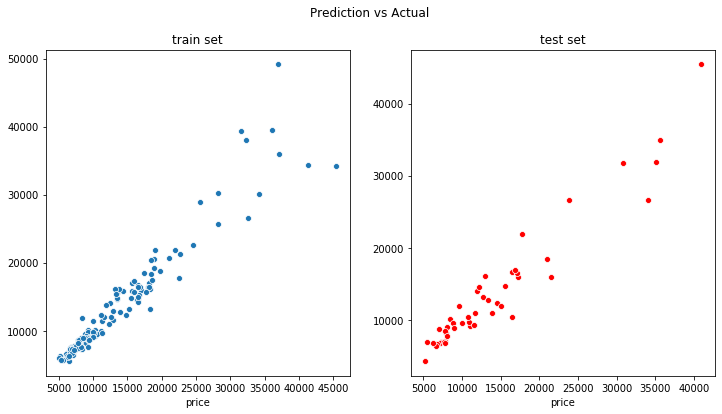

In [64]:
#Final Model
pipe = generate_ridge_model(alpha=1)

pipe.fit(X_train_s, y_train_s)
print(cross_val_score(pipe, pd.concat([X_train_s, X_test_s], axis=0), pd.concat([y_train_s, y_test_s], axis=0), cv=10))
print('Train mae', mean_absolute_error(y_train_s, pipe.predict(X_train_s)))
print('Test mae', mean_absolute_error(y_test_s, pipe.predict(X_test_s)))
evaluate_model(pipe, X_train_s, y_train_s, X_test_s, y_test_s)

In [65]:
from sklearn.inspection import permutation_importance

feature_importance = permutation_importance(pipe, X_train_s, y_train_s,
                        n_repeats=10,
                        random_state=0)

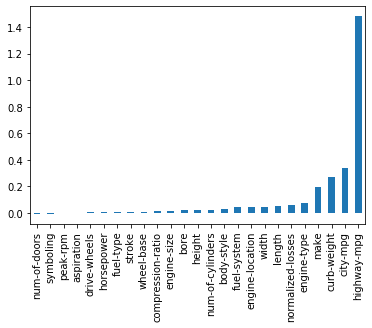

In [66]:
fi = pd.DataFrame(feature_importance['importances'].T, columns=X_train_s.columns).mean().sort_values()
fi.plot.bar()

In [68]:
for i in range(len(X_train_s.columns) - 1):
    columns_selected = fi.index[i:]
    
    ct = ColumnTransformer([("onehot", OneHotEncoder(sparse=False, handle_unknown ='ignore'), X_train_s[columns_selected].select_dtypes('object').columns),
                            ("standard_scaler", StandardScaler(), X_train_s[columns_selected].select_dtypes(exclude='object').columns)])
    model = TransformedTargetRegressor(regressor=Ridge(alpha=1),
                                       transformer=PowerTransformer(method='box-cox'))
    pipe = Pipeline([('feature_transformation', ct),
                     ('model', model)])
    X_cv = pd.concat([X_train_s[columns_selected], X_test_s[columns_selected]], axis=0)
    y_cv = pd.concat([y_train_s, y_test_s], axis=0)
    
    cv_score = cross_val_score(pipe, X_cv, y_cv, cv=5).mean()
    print(f'number of features: {len(X_cv.columns)}', f' mean cv r2: {cv_score}')

number of features: 25  mean cv r2: 0.8600990640199679
number of features: 24  mean cv r2: 0.74958382710653
number of features: 23  mean cv r2: 0.8142313377992
number of features: 22  mean cv r2: 0.7931115545282232
number of features: 21  mean cv r2: 0.7846116405408006
number of features: 20  mean cv r2: 0.8201224604701226
number of features: 19  mean cv r2: 0.8831288442252292
number of features: 18  mean cv r2: 0.8811275840563948
number of features: 17  mean cv r2: 0.8859531937076266
number of features: 16  mean cv r2: 0.8860288028457605
number of features: 15  mean cv r2: 0.8843570196756995
number of features: 14  mean cv r2: 0.887171631641022
number of features: 13  mean cv r2: 0.8871691414271845
number of features: 12  mean cv r2: 0.8911946841010581
number of features: 11  mean cv r2: 0.8922106458439533
number of features: 10  mean cv r2: 0.8985923002768692
number of features: 9  mean cv r2: 0.8100246362124368
number of features: 8  mean cv r2: 0.8011710414425313
number of features

In [ ]:
#import statsmodels.api as sm
#X_sm = sm.add_constant(X_train)
#model = sm.OLS(y_train_trans,X_sm).fit()
#model.summary()
#from statsmodels.stats.outliers_influence import variance_inflation_factor
#vif = pd.DataFrame(np.zeros((1,len(X.columns))),columns=X.columns)
#vif.iloc[0,:] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]